Code for generating Figure 5D.

In [1]:
import math
import os
import anndata
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from itertools import groupby
from matplotlib import gridspec
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.gridspec as gridspec

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

/home/kjs6397/.conda/envs/pasc_revisions_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mpl.font_manager.fontManager.addfont(f"/projects/b1038/Pulmonary/nmarkov/2022-script-atlas/code/fonts/Arial.ttf")
mpl.font_manager.fontManager.addfont(f"/projects/b1038/Pulmonary/nmarkov/2022-script-atlas/code/fonts/Arial Italic.ttf")
        
mpl.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42

In [3]:
data_dir = "/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data"

In [4]:
DIR = "/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data/22deg-analysis/all_groups_w_controls/pseudobulk/input"

### Grab genes to be used in heatmap

In [5]:
heatmap_genes = pd.read_csv(f"{data_dir}/27final-plots/heatmap_genes.csv", index_col=0)

In [6]:
heatmap_genes = heatmap_genes.index.unique().tolist()

### Load object

In [7]:
adata = sc.read_h5ad(f'{DIR}/all_groups_w_controls_pseudobulk.h5ad')

In [8]:
adata = adata[adata.obs.Study.isin(['Reyfman', 'Bharat', 'Bailey'])]

In [9]:
adata.obs['cell_type_level2'] = adata.obs.cell_type.copy()

/tmp/ipykernel_225575/2797709043.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type_level2'] = adata.obs.cell_type.copy()


### Rename cell types

In [10]:
rename_map = {'MoAM-1': 'MP1', 
              'MoAM-2': 'MP2',
              'TRAM-1': 'MP3',
              'TRAM-2': 'MP4',
              'TRAM-3': 'MP5',
             }

adata.obs['cell_type'] = adata.obs['cell_type'].map(rename_map).fillna(adata.obs['cell_type'])

In [11]:
adata = adata[adata.obs.cell_type.isin(["MP1", "MP2", "MP3", "MP4", "MP5"])]

### Rename "Status" values in Bailey dataset
Create two categories - RPRA and healthy

In [12]:
bailey_subset = adata[adata.obs.Study == 'Bailey']

bailey_subset.obs['Status'] = bailey_subset.obs['Status'].apply(lambda x: 'RPRA' if x != 'Healthy' else x)

adata.obs.loc[adata.obs.Study == 'Bailey', 'Status'] = bailey_subset.obs['Status']
adata.obs['Status'] = adata.obs['Status'].astype('category')
adata.obs['Status'].cat.remove_unused_categories(inplace=True)

/tmp/ipykernel_225575/3842141835.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bailey_subset.obs['Status'] = bailey_subset.obs['Status'].apply(lambda x: 'RPRA' if x != 'Healthy' else x)
/tmp/ipykernel_225575/3842141835.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Status'] = adata.obs['Status'].astype('category')


In [13]:
adata[adata.obs.Study == 'Bailey'].obs.Status.unique()

['RPRA', 'Healthy']
Categories (2, object): ['Healthy', 'RPRA']

### Add Study_ID column to dataframe
This will contain dataset identifier (GSEXXXXXX)

In [14]:
adata.obs['Study_ID'] = adata.obs['Study'].copy()

In [15]:
adata.obs.Study_ID = adata.obs.Study_ID.replace({
                           'Reyfman': 'GSE122960',
                           'Bailey': 'GSE232627',
                           'Bharat': 'GSE158127'})

### Subset on genes found in the adata object
Not all genes found in `heatmap_genes.csv` are in the adata object - some were previously filtered out.

Which genes are not in the adata object?

In [16]:
[gene for gene in heatmap_genes if gene not in adata.var_names]

['MT-ND4',
 'MT-ATP6',
 'MT-ND1',
 'MT-ND2',
 'LINC01943',
 'RPS27',
 'MT-ATP8',
 'AC013457.1',
 'GAS5',
 'AC243960.1',
 'PCED1B-AS1',
 'RESF1']

In [17]:
heatmap_genes = ([gene for gene in heatmap_genes if gene in adata.var_names])

In [18]:
len(heatmap_genes)

115

### Get dataframe of raw gene counts

In [19]:
raw_counts = pd.DataFrame(adata.layers["counts"].todense(),
                          index = adata.obs_names,
                          columns = adata.var_names)

In [20]:
raw_counts = raw_counts.loc[:, heatmap_genes]

### Convert to pseudobulk

In [22]:
pb_counts = raw_counts.groupby([adata.obs["Study_ID"], adata.obs["cell_type"], adata.obs["sample"]]).agg(['sum', 'size'])

### Filter
Require a minimum of 10 cells

In [23]:
pb_counts = pb_counts[pb_counts[pb_counts.columns[1]] >= 10]

### Reformat dataframe
Remove size columns

In [24]:
pb_counts = pb_counts[[col for col in pb_counts.columns if col[1] != 'size']]

Flatten columns

In [25]:
pb_counts.columns = [c[0] for c in pb_counts.columns]

Flatten index

In [26]:
pb_counts.index = ['_'.join(map(str, idx)) for idx in pb_counts.index]

### Add Study, cell type, and Study ID to each row

In [28]:
pb_counts["Study_ID"] = [x.split('_')[0] for x in pb_counts.index]

In [29]:
pb_counts["cell_type"] = [x.split('_')[1] for x in pb_counts.index]

In [30]:
sample_to_status = dict(zip(adata.obs['sample'], adata.obs['Status']))

def extract_sample(index):
    return '_'.join(index.split('_')[2:4])

pb_counts['Status'] = [sample_to_status.get(extract_sample(x), 'Unknown') for x in pb_counts.index]

In [31]:
cell_types = ['MP1', 'MP2', 'MP3', 'MP4', 'MP5']

### Order cell types and statuses

In [33]:
pb_counts.Status = pd.Categorical(pb_counts.Status)
pb_counts.Status = pb_counts.Status.cat.set_categories(["RPRA", "COVID-19", "IPF", "Healthy", "Control", "Donor"], ordered = True)

mapping = {
    "RPRA": "Fibrosis",
    "COVID-19": "Fibrosis",
    "IPF": "Fibrosis",
    "Healthy": "Control",
    "Control": "Control",
    "Donor": "Control"
}
pb_counts['Status'] = pb_counts.Status.map(mapping).astype('category')

pb_counts.cell_type = pd.Categorical(pb_counts.cell_type)
pb_counts.cell_type = pb_counts.cell_type.cat.set_categories(cell_types, ordered = True)

pb_counts.Study_ID = pd.Categorical(pb_counts.Study_ID)
pb_counts.Study_ID = pb_counts.Study_ID.cat.set_categories(['GSE232627', 'GSE158127', 'GSE122960'], ordered = True)

pb_counts = pb_counts.sort_values(by = ['Status', 'cell_type', 'Study_ID'])
pb_counts = pb_counts.set_index(['Status', 'cell_type', 'Study_ID'])

### Normalize pseudobulked counts

In [35]:
pb_counts_per_sample = 1 + pb_counts.sum(axis = 1)
normalized_counts = np.log1p((pb_counts.T / pb_counts_per_sample).T * 10000)

### Standard score expression for each gene

In [36]:
normalized_counts = normalized_counts.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

### Record metadata

In [37]:
status = normalized_counts.index.get_level_values(0).tolist()
cell_type = normalized_counts.index.get_level_values(1).tolist()
study = normalized_counts.index.get_level_values(2).tolist()

In [38]:
normalized_counts = normalized_counts.reset_index(level=1, drop=True)

In [39]:
color_map = {"Control": (0, 0, 1), "Fibrosis": '#DC143C'}
status_colors = [color_map[element] for element in status]

In [40]:
color_map_cell_type = {
                   "MP1": "#E64B35FF",
                   "MP2": "mediumpurple",
                   "MP3": '#00A087FF',
                   "MP4": 'cornflowerblue', 
                   "MP5": '#F39B7FFF'}
cell_type_colors = [color_map_cell_type[element] for element in cell_type]

In [41]:
color_map_study = {"GSE232627": 'darkgreen',
                   "GSE158127": 'royalblue', 
                   "GSE122960": 'firebrick'}
study_colors = [color_map_study[element] for element in study]

### Hierarchical clustering of genes

In [42]:
mat = normalized_counts.T
row_linkage = linkage(mat, method='ward')
row_order = dendrogram(row_linkage, no_plot=True)['leaves']
mat = mat.iloc[row_order, :]

In [43]:
reversed_section = mat.iloc[0:76].iloc[::-1].set_index(mat.index[0:76][::-1])
mat = pd.concat([reversed_section, mat.iloc[76:]], axis=0)
mat

Status     Control                                                    \
Study_ID GSE232627 GSE232627 GSE232627 GSE232627 GSE232627 GSE158127   
H1FX      0.383339  0.625029  0.600499  0.517388  0.533034  0.749472   
STK17A    0.380133  0.481323  0.317956  0.394312  0.214851  1.000000   
LCP2      0.417955  0.406242  0.443916  0.533654  0.530449  1.000000   
HSPA1A    0.480385  0.276992  0.455188  0.617839  0.438586  0.894336   
KLF2      0.635218  0.447435  0.491112  0.635528  0.566612  0.787197   
...            ...       ...       ...       ...       ...       ...   
TMEM176A  0.697979  0.898681  0.701894  0.913866  0.861217  0.585168   
FCN1      0.709054  0.896611  0.753916  0.690457  0.843036  0.742499   
LIMD2     0.654224  0.687324  0.796834  0.638029  0.440136  0.801661   
FCGR2B    0.728881  0.752270  0.717574  0.865400  0.664703  0.819699   
CORO1A    0.684752  0.778106  0.880318  0.778755  0.632565  0.890056   

Status                                            ...  Fibrosis            \
Study_ID GSE158127 GSE122960 GSE122960 GSE122960  ... GSE232627 GSE232627   
H1FX      0.941853  0.454585  0.309236  0.538787  ...  0.480969  0.350211   
STK17A    0.800073  0.508337  0.303605  0.579563  ...  0.305491  0.316973   
LCP2      0.957209  0.505257  0.535303  0.587764  ...  0.303103  0.394749   
HSPA1A    0.849893  0.818846  0.285174  0.288055  ...  0.402517  0.382473   
KLF2      0.915056  0.755687  0.367868  0.511460  ...  0.354660  0.372254   
...            ...       ...       ...       ...  ...       ...       ...   
TMEM176A  0.934554  0.718015  0.601441  0.427827  ...  0.748685  0.796047   
FCN1      0.804510  0.376201  0.680653  0.298558  ...  0.126215  0.513226   
LIMD2     0.877265  0.522401  0.647086  0.346251  ...  0.149247  0.330819   
FCGR2B    1.000000  0.788894  0.799870  0.679184  ...  0.261042  0.296255   
CORO1A    1.000000  0.759743  0.824438  0.499071  ...  0.261715  0.318683   

Status                                                                \
Study_ID GSE232627 GSE232627 GSE158127 GSE158127 GSE158127 GSE122960   
H1FX      0.397838  0.536167  0.797234  0.676671  0.745754  0.000000   
STK17A    0.316406  0.337049  0.865185  0.751623  0.795482  0.336127   
LCP2      0.370309  0.345239  0.813270  0.718780  0.720333  0.359497   
HSPA1A    0.388049  0.382187  0.630609  0.888951  0.951163  0.254119   
KLF2      0.651179  0.303893  0.943968  1.000000  0.992855  0.160728   
...            ...       ...       ...       ...       ...       ...   
TMEM176A  0.541748  0.194382  0.714943  0.784517  0.824316  0.283858   
FCN1      0.559810  0.306342  0.695418  0.723119  0.791196  0.474590   
LIMD2     0.629058  0.206073  0.585500  0.523090  0.653895  0.033323   
FCGR2B    0.646324  0.063520  0.811552  0.685174  0.745138  0.150006   
CORO1A    0.482892  0.245356  0.752837  0.642064  0.664365  0.307042   

Status                        
Study_ID GSE122960 GSE122960  
H1FX      0.210711  0.151280  
STK17A    0.316784  0.446708  
LCP2      0.511930  0.434613  
HSPA1A    0.352601  0.359193  
KLF2      0.212790  0.330365  
...            ...       ...  
TMEM176A  0.418216  0.207194  
FCN1      0.278219  0.202820  
LIMD2     0.362663  0.064332  
FCGR2B    0.527856  0.214543  
CORO1A    0.449578  0.200299  

[115 rows x 217 columns]

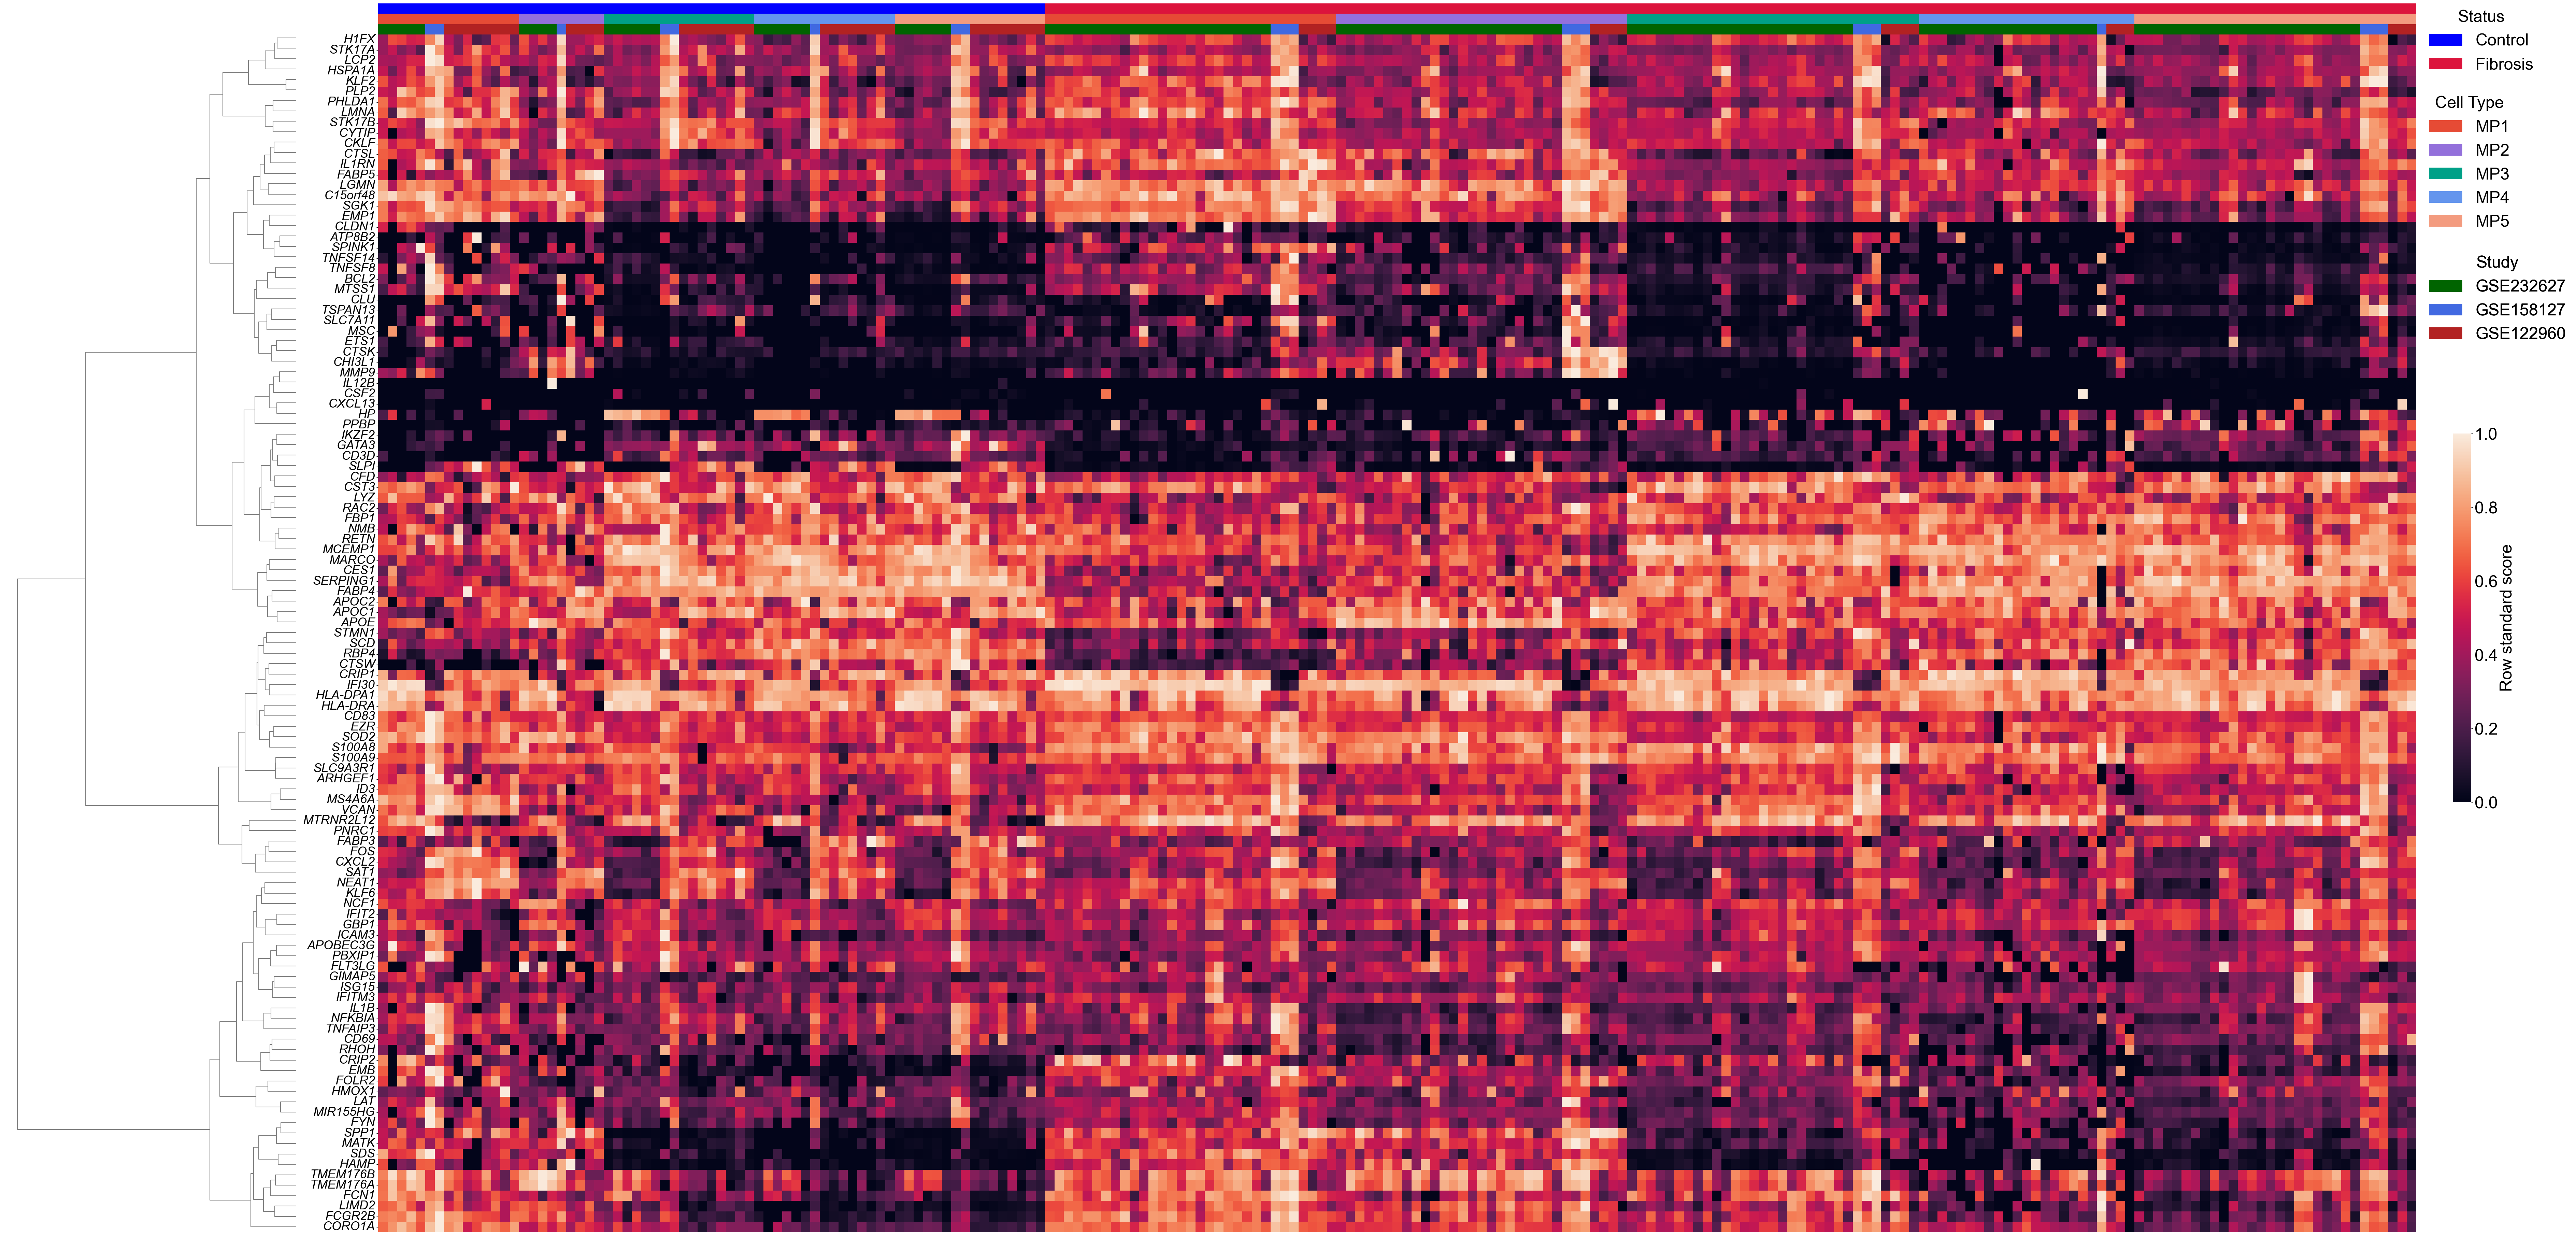

In [44]:
mpl.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
fig = plt.figure(figsize=(60, 45))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 10], wspace=0.06)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

sns.heatmap(mat, cbar_kws={"shrink": 0.3, "pad": 0.015}, linecolor='black',
            xticklabels=False, yticklabels=True, ax=ax1)
cbar = ax1.collections[0].colorbar
cbar.set_label('Row standard score', fontsize=35)
cbar.ax.yaxis.set_tick_params(labelsize=35)
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='both', bottom=False)

ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=26, style = 'italic')

dendro = dendrogram(row_linkage, orientation='left', ax=ax0, above_threshold_color='gray',
                    color_threshold=0)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.spines['bottom'].set_visible(False)

annotation_height = 1 
ax0.set_ylim((ax0.get_ylim()[0], ax0.get_ylim()[1] + 28))
ax1.set_ylim((ax1.get_ylim()[0], ax1.get_ylim()[1] - 3))

for i in range(len(normalized_counts)):
    study_c = study_colors[i]
    status_c = status_colors[i]
    cell_type_c = cell_type_colors[i]
    ax1.add_patch(patches.Rectangle((i, -3), 1, annotation_height, facecolor=status_c)) # Status annotation
    ax1.add_patch(patches.Rectangle((i, -2), 1, annotation_height, facecolor=cell_type_c)) # Cell type annotation
    ax1.add_patch(patches.Rectangle((i, -1), 1, annotation_height, facecolor=study_c)) # Study annotation

study_labels = list(color_map_study.keys())
status_labels = list(color_map.keys())
cell_type_labels = list(color_map_cell_type.keys())

def create_legend(ax, labels, colors, title, bbox_anchor, fontsize=15):
    patches = [Rectangle((0, 0), 1, 1, facecolor=color) for color in colors]
    legend = ax.legend(
        patches, 
        labels, 
        title=title, 
        bbox_to_anchor=bbox_anchor, 
        loc='upper left', 
        borderaxespad=0., 
        frameon=False, 
        fontsize=fontsize,  
        title_fontsize=fontsize  
    )
    return legend

status_legend = create_legend(ax1, status_labels, [color_map[label] for label in status_labels], 'Status', (1.003, 1), fontsize=35)
cell_type_legend = create_legend(ax1, cell_type_labels, [color_map_cell_type[label] for label in cell_type_labels], 'Cell Type', (1.003, 0.93), fontsize=35)
study_legend = create_legend(ax1, study_labels, [color_map_study[label] for label in study_labels], 'Study', (1.003, 0.8), fontsize=35)


ax1.add_artist(study_legend)
ax1.add_artist(status_legend)
ax1.add_artist(cell_type_legend)

plt.subplots_adjust(right=1.5, top=0.9, bottom=0.1)

plt.savefig("/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data/figures/fig_5/fig5c_revised-v2.pdf", bbox_inches='tight', pad_inches=2)
plt.show()